# ASSIGNMENT 3 

#### Machine Learning in Korea University
#### COSE362, Fall 2018
#### Due : 12/18 (THU) 11:59 PM

#### In this assignment, you will implement and train a Recommender System. Also, you will learn how to utilize scikit-learn to analyze data using clustering.
* Implemented using Anaconda 5.3 with python 3.7. Please use <b>python 3</b>
* Use given dataset. Please do not change data split.
* Use numpy, scikit-learn, and matplotlib library
* You don't have to use all imported packages below. (some are optional). <br>
* <b>*DO NOT MODIFY OTHER PARTS OF CODES EXCEPT "Your Code Here"*</b>


### 1. Recommender System

In the problem 1, you will implement a simple recommender system.
* See your lecture note (Lecture 15. Recommender Systems - Collaborative filtering). 
* Do not implement matrix factorization and Do not import any other packages and libraries. <b>You should use only numpy</b>.
* Analyze train and validation error. <br>

### Dataset description : MovieLens Dataset


Here are brief descriptions of the data.

><b>u.data</b>     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC

><b>u1.base</b> -- Subset of u.data. You should use u1.base at training time. <br>
><b>u1.test</b> -- Subset of u.data. You should use u1.test at testing.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)

In [2]:

with open('./data/u.info') as f:
    info = f.readlines()
    num_users = int(info[0].split()[0])
    num_movies = int(info[1].split()[0])

def read_data(file_name):
    with open('./data/' + file_name) as f:
        dataset = []
        cnt = 0
        while True:
            line = f.readline()
            if not line: break
            d = list(map(int, line.split()[:3]))
            d[0] -= 1
            d[1] -= 1
            dataset.append(d)
    return dataset

###########################################

train_dataset = read_data('u1.base')
valid_dataset = read_data('u1.test')


### 1 - (1) Design your recommender system model.

##### Instructions <br>
* <b>\__init\__</b> : configure model. <b>DO NOT MODIFY</b>.
* <b>compute_loss</b> : compute loss between user i and movie j.
* <b>update</b> : update the parameter of user i and movie j with gradient descent.
* <b>run_epoch</b> : train one iteration of collaborative filtering. <b>If "trainable=False", this function doesn't update parameters.</b> <br>
<t>The variable "trainable" is false when the model is on validation or test.
    

<br>* <b>loss</b> --> see your lecture note.
<br>* <b>rmse</b> indicates Root Mean Square Error that is widely used for rating prediction evaluation.

In [3]:

class RecommenderSystem():
    def __init__(self, num_users, num_movies, user_size, movie_size, learning_rate, reg_coef):
        self.user_mat = np.random.normal(0, 1, (num_users, user_size))
        self.movie_mat = np.random.normal(0, 1, (num_movies, movie_size))
        self.learning_rate = learning_rate
        self.reg_coef = reg_coef
        self.loss = 0.0
    
    def compute_loss(self, i, j, rating):
        # Your Code Here
        target = 0
        loss = ((np.dot(self.user_mat[i], self.movie_mat[j]) - rating) ** 2) / self.user_mat.shape[1]
        # End Your Code
        return target, loss
        
    def update(self, target, i, j, rating):
        # Your Code Here
        temp_u = self.user_mat[i]
        temp_m = self.movie_mat[j]
        for k in range(self.user_mat.shape[1]):
            self.user_mat[i][k] = temp_u[k] - self.learning_rate * ((np.dot(temp_u, temp_m) - rating)\
                                                              * temp_m[k] + self.reg_coef * temp_u[k])
            self.movie_mat[j][k] = temp_m[k] - self.learning_rate * ((np.dot(temp_u, temp_m) - rating)\
                                                              * temp_u[k] + self.reg_coef * temp_m[k])
        # End Your Code
        ##

    def run_epoch(self, dataset, trainable=False):
        loss_sum = rmse_sum = target_sum = 0
        np.random.shuffle(dataset)
        for s_idx, sample in enumerate(dataset):
        # Your Code Here
            i, j, rating = sample
            _, loss = self.compute_loss(i, j, rating)
            loss_sum += loss
            rmse_sum += np.sqrt(loss)
            if trainable:
                self.update(_, i, j, rating)
        rmse = rmse_sum / len(dataset)
        # End Your Code
        return loss_sum / len(dataset), rmse

    

In [4]:

def main(config):
    #####
    # optimal : (int) the epoch where validation loss is minimum
    # eps : (list) a list of training epochs
    # loss_tr : (list) a list of training losses
    # loss_va : (list) a list of validation losses
    # rmse_tr : (list) a list of training rmse(root mean square error)
    # rmse_va : (list) a list of validation rmse(root mean square error)
    
    model = RecommenderSystem(num_users, num_movies,
                            config['user_size'],
                             config['movie_size'],
                             config['learning_rate'],
                             config['reg_coef'])
    
    min_loss = optimal = 99999
    eps, loss_tr, loss_va, rmse_tr, rmse_va  = [], [], [], [], []
    for epoch in range(config['max_epoch']):
        # ls_tr : mean of total losses in an epoch
        # e_tr : mean of total root mean square errors in an epoch
        ls_tr, e_tr = model.run_epoch(train_dataset, trainable=True)
        ls_va, e_va = model.run_epoch(valid_dataset, trainable=False)
        
        # Your Code Here
        eps.append(epoch)
        loss_tr.append(ls_tr)
        loss_va.append(ls_va)
        rmse_tr.append(e_tr)
        rmse_va.append(e_va)
        if (epoch+1) % config['eval_step'] == 0:
            print("ep:{} ### Train # Loss={:5.3f}, RMSE={:5.3f}".format(epoch+1, ls_tr, e_tr))
            print("ep:{} %%% Valid % Loss={:5.3f}, RMSE={:5.3f}".format(epoch+1, ls_va, e_va)) 
        if min_loss > ls_va:
            min_loss = ls_va
            optimal = epoch
        # End Your Code
    return optimal, eps, loss_tr, loss_va, rmse_tr, rmse_va, model

###################################################################

config = {'user_size': 10,
         'movie_size': 10,
         'learning_rate': 0.01,
         'reg_coef': 0.001,
         'max_epoch': 50,
         'eval_step': 5}

optimal, eps, loss_tr, loss_va, rmse_tr, rmse_va, model = main(config)
print ("\[Exp have been finished !]\nOptimal : {}, Train loss : {:2.3f}, Valid loss : {:2.3f}, RMSE : {:3.2f}"
       .format(optimal, loss_tr[optimal], loss_va[optimal], rmse_va[optimal]))

ep:5 ### Train # Loss=0.106, RMSE=0.252
ep:5 %%% Valid % Loss=0.168, RMSE=0.305
ep:10 ### Train # Loss=0.084, RMSE=0.228
ep:10 %%% Valid % Loss=0.141, RMSE=0.282
ep:15 ### Train # Loss=0.078, RMSE=0.219
ep:15 %%% Valid % Loss=0.135, RMSE=0.276
ep:20 ### Train # Loss=0.074, RMSE=0.213
ep:20 %%% Valid % Loss=0.133, RMSE=0.274
ep:25 ### Train # Loss=0.071, RMSE=0.209
ep:25 %%% Valid % Loss=0.132, RMSE=0.273
ep:30 ### Train # Loss=0.069, RMSE=0.206
ep:30 %%% Valid % Loss=0.131, RMSE=0.272
ep:35 ### Train # Loss=0.067, RMSE=0.203
ep:35 %%% Valid % Loss=0.132, RMSE=0.272
ep:40 ### Train # Loss=0.065, RMSE=0.200
ep:40 %%% Valid % Loss=0.132, RMSE=0.273
ep:45 ### Train # Loss=0.064, RMSE=0.198
ep:45 %%% Valid % Loss=0.132, RMSE=0.273
ep:50 ### Train # Loss=0.063, RMSE=0.196
ep:50 %%% Valid % Loss=0.132, RMSE=0.272
\[Exp have been finished !]
Optimal : 29, Train loss : 0.069, Valid loss : 0.131, RMSE : 0.27


### 1 - (2) Plot the training and validation loss against epochs and Analyze.
 


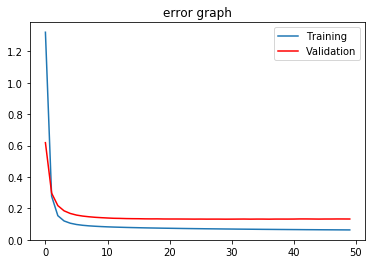

In [9]:
# Plot your train error and validation error by number of iterations.
plt.plot(eps, loss_tr, eps, loss_va, 'r-')
plt.title("error graph")
plt.legend(["Training", "Validation"])
plt.show()


##### Analyze the result.

# Write description here
학습을 계속 할 수록 training error는 지속적으로 줄어들지만 약 29번 째 epoch부터 overfitting이 일어나
validation error는 더 이상 줄어들지 않고 오히려 약간 올라가는 양상을 보인다.


## 2. Clustering

In the problem 2, you would learn how to analyze data with unsupervised learning algorithm.
* Implement <b>k-means clustering</b> algorithm using <b>scikit-learn packages</b>. <br>
* Visualize your result and analyze. <br>
* Implement <b>PCA(principle component analysis)</b> and visualize your data onto 2-dimensional domain, and visualize your data by class-labels.

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import cluster
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_samples = 3000
random_state = 1182
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

### 2 - (1) Implement K-means clustering algorithm and visualize data with class labels.
For given data, find the best number of clusters (each cluster is well-divided). <br>
Visualize your results using <b>scatter plot</b>. 

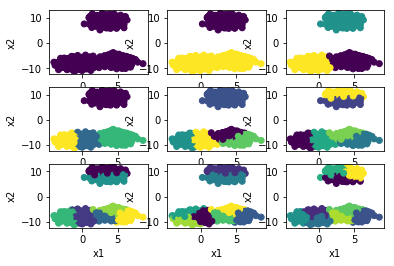

The optimal number of clusters based on elbow method is:  2


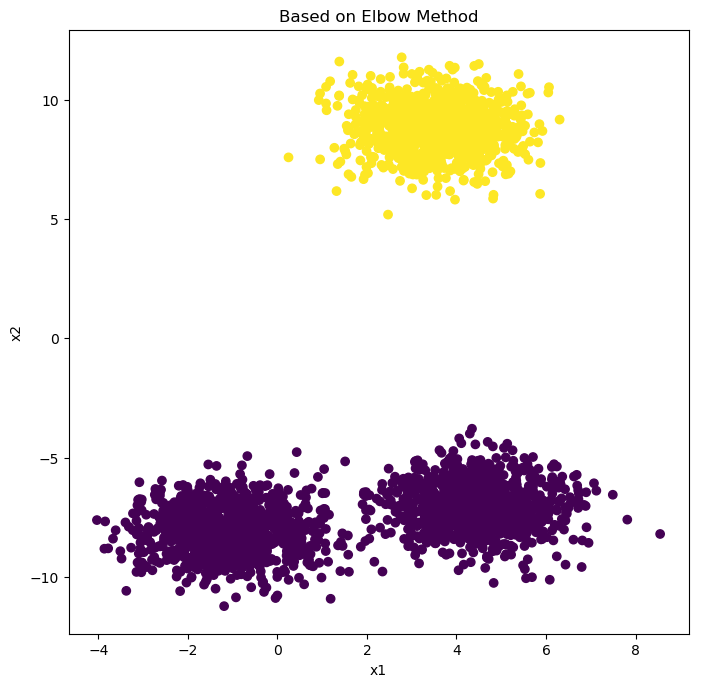

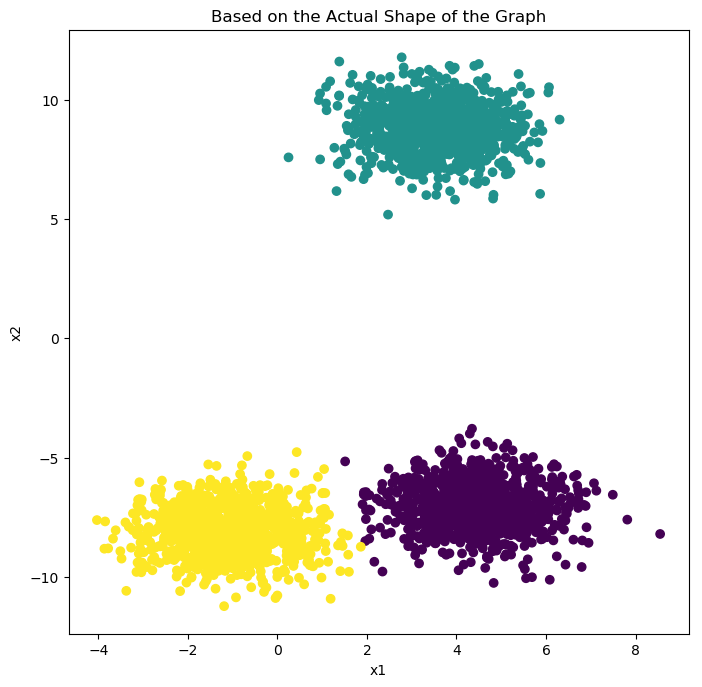

In [4]:
# Use sklearn.cluster.KMeans for k-means clustering
# Use plt.scatter for visualization

# Your Code Here
scores = []
clusters = list(range(1, 10))
for num in clusters:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(X)
    plt.subplot(3, 3, num)
    plt.scatter(X[:,0], X[:,1], c = kmeans.predict(X))
    plt.xlabel("x1")
    plt.ylabel("x2")
    scores.append(kmeans.inertia_)
plt.show()

# for finding the best K by elbow method
distances = []
p1 = np.array((1, scores[0]))
p2 = np.array((len(scores), scores[-1]))
i = 1
for p in scores:
    distances.append(np.cross(p2-p1, p1-np.array((i, p)))/np.linalg.norm(p2-p1))
    i += 1
opt_k = distances.index(max(distances)) + 1 
print("The optimal number of clusters based on elbow method is: ", opt_k)

kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(X)
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X[:,0], X[:,1], c = kmeans.predict(X))
plt.title("Based on Elbow Method")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(X[:,0], X[:,1], c = kmeans.predict(X))
plt.title("Based on the Actual Shape of the Graph")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
# End Your Code

### 2 - (2) Implement PCA and visualize data with class labels.
Conduct K-means clustering on given data. <br>
Implement <b>PCA(principle component analysis)</b> to convert high-dimensional vectors into 2-dimensional vectors. <br>
Compare plots by K-means result and class labels by visualization. <br>
* Dataset : Handwritten digit dataset (Class : digit, Data : digit image)
* Visualize <b>two scatter plots</b>. (One for class label and one for k-means clustering)

The optimal number of clusters based on elbow method is :  3





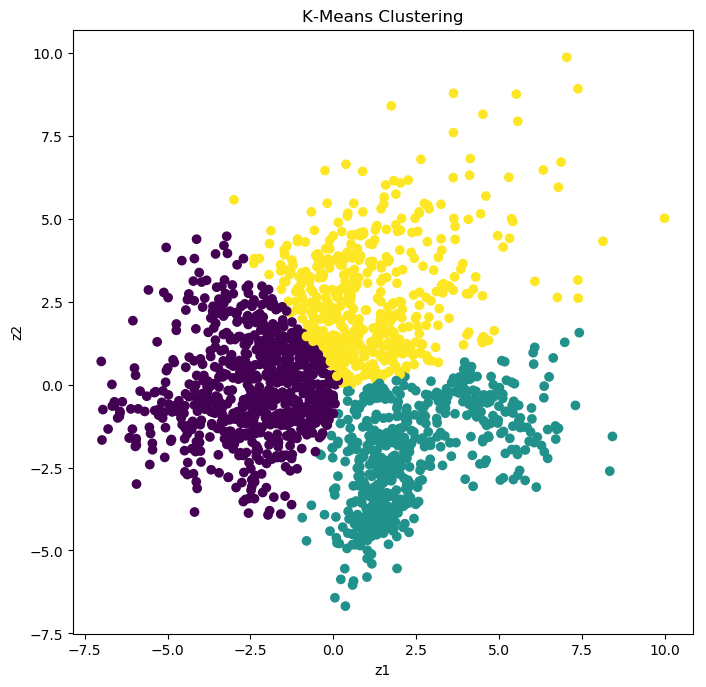

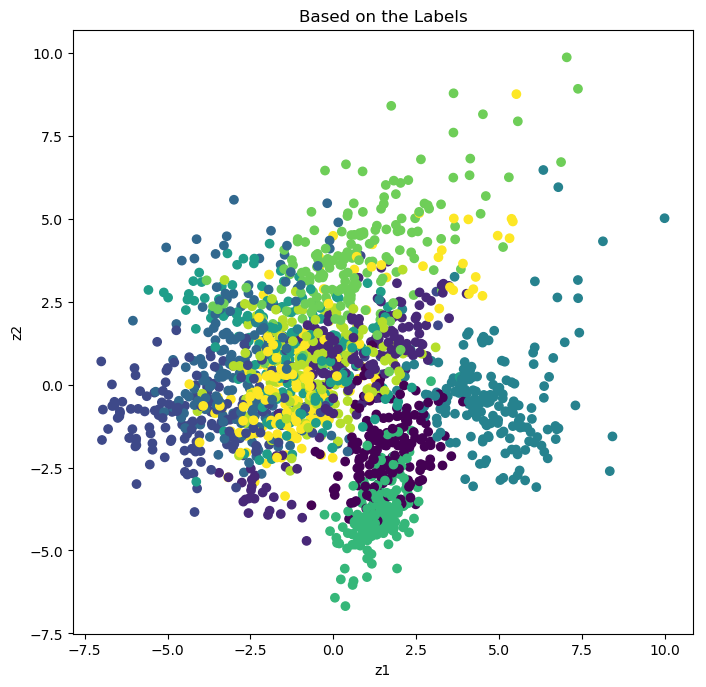

In [5]:
# use sklearn.decomposition.PCA

digits = load_digits()
data = scale(digits.data)
labels = digits.target

# Your Code Here
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)
scores = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_reduced)
    scores.append(kmeans.inertia_)

# for finding the best K by elbow method
distances = []
p1 = np.array((1, scores[0]))
p2 = np.array((len(scores), scores[-1]))
i = 1
for p in scores:
    distances.append(np.cross(p2-p1, p1-np.array((i, p)))/np.linalg.norm(p2-p1))
    i += 1
opt_k = distances.index(max(distances)) + 1 
print("The optimal number of clusters based on elbow method is : ", opt_k)
print("\n\n\n", "="*40)

kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(data_reduced)
plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c = kmeans.predict(data_reduced))
plt.title("K-Means Clustering")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

plt.figure(figsize=(8, 8), dpi=100)
plt.scatter(data_reduced[:,0], data_reduced[:,1], c = labels)
plt.title("Based on the Labels")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()
# End Your Code
